## Project 4.5. Neural network classification - stroke prediction
Key things:
* Imbalanced dataset - with classical techniques, we were only able to achieve high recall (true positive count) with a tradeoff of high false positive rate - but, it fit our "business value"
* Can neural networks achieve high recall on minority class, without sacrificing precision? Can we get a better precision-recall curve?
* Tensorflow first
* Tested on raw, cleaned data and with engineered features
* Will class weighting be necessary? How possible is it? Tuning the output prediction threshold necessary?
* Hyperparameter search?
* Output and intermediary activation functions etc explorations

### Code setup

In [1]:
import pandas as pd
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# classification
from sklearn.svm import SVC
from sklearn.metrics  import (f1_score ,accuracy_score, confusion_matrix,
                            classification_report, ConfusionMatrixDisplay, 
                            roc_curve, precision_recall_curve,
                            auc, make_scorer, recall_score, accuracy_score, precision_score
                            )

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [2]:
tf.random.set_seed(111)

#### Datasets
* df - raw dataset
* df_eng - bmi values imputed, 'yes'/'no' changed to 0/1
* df_enc - categorical values one-hot and ordinally (smoking) encoded

In [3]:
df_path = '../datasets/stroke_data.csv'
df_eng_path = '../datasets/stroke_data_eng.csv'
df_enc_path = '../datasets/stroke_data_enc.csv'
df = pd.read_csv(df_path, index_col=0)
df_eng = pd.read_csv(df_eng_path, index_col=0)
df_enc = pd.read_csv(df_enc_path, index_col=0)

In [5]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
df_eng.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,1,Private,Urban,228.69,36.600000,formerly smoked,1
51676,Female,61.0,0,0,1,Self-employed,Rural,202.21,28.893237,never smoked,1
31112,Male,80.0,0,1,1,Private,Rural,105.92,32.500000,never smoked,1
60182,Female,49.0,0,0,1,Private,Urban,171.23,34.400000,smokes,1
1665,Female,79.0,1,0,1,Self-employed,Rural,174.12,24.000000,never smoked,1


In [7]:
df_enc.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke,Female,Male,Other,Govt_job,Never_worked,Private,Self-employed,children,Rural,Urban
id,,,,,,,,,,,,,,,,,,
9046,67.0,0,1,1,228.69,36.600000,1,1,False,True,False,False,False,True,False,False,False,True
51676,61.0,0,0,1,202.21,28.893237,0,1,True,False,False,False,False,False,True,False,True,False
31112,80.0,0,1,1,105.92,32.500000,0,1,False,True,False,False,False,True,False,False,True,False
60182,49.0,0,0,1,171.23,34.400000,2,1,True,False,False,False,False,True,False,False,False,True
1665,79.0,1,0,1,174.12,24.000000,0,1,True,False,False,False,False,False,True,False,True,False


In [9]:
df_enc.dtypes

age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
stroke                 int64
Female                  bool
Male                    bool
Other                   bool
Govt_job                bool
Never_worked            bool
Private                 bool
Self-employed           bool
children                bool
Rural                   bool
Urban                   bool
dtype: object

### EDA
Even though we looked at the data more in-depth in Project 3, let's refresh at least the data distributions

In [10]:
cols = df.columns

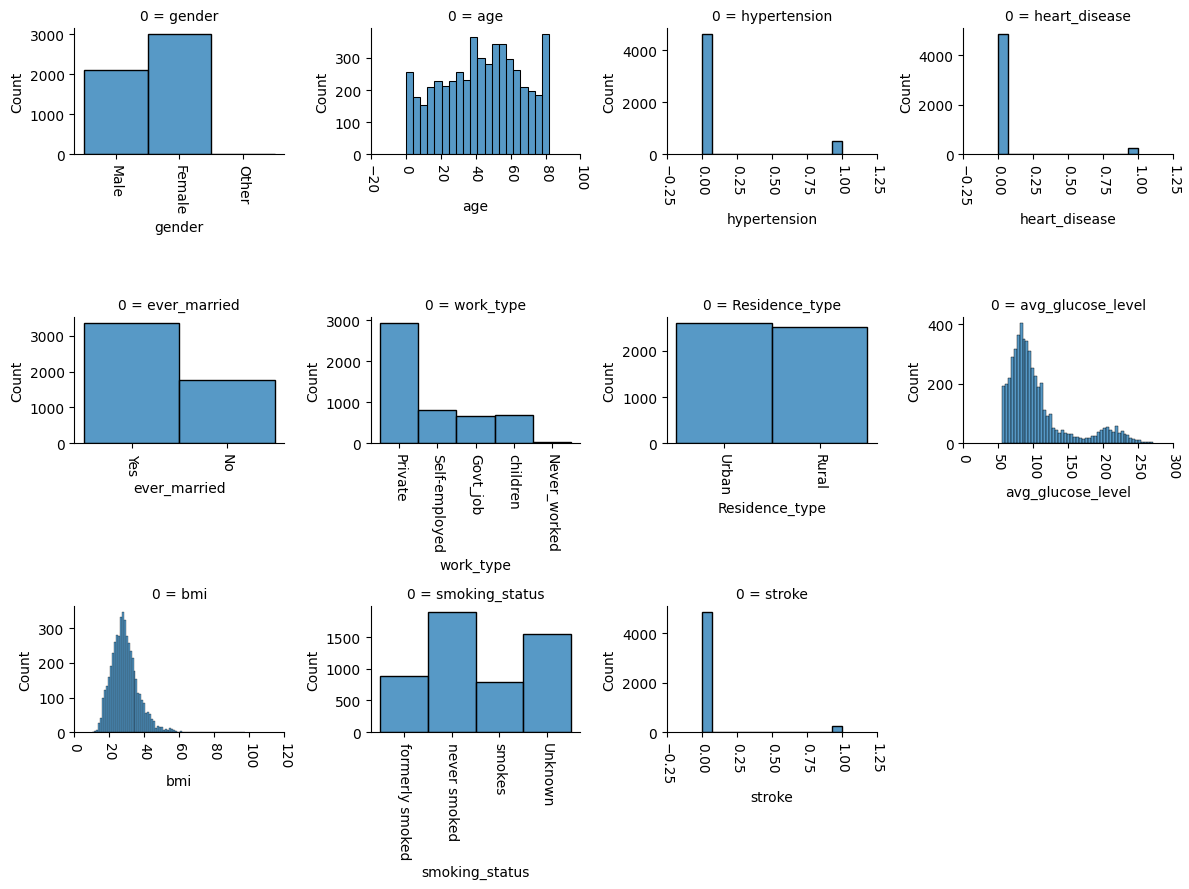

In [11]:
g = sns.FacetGrid(pd.DataFrame(list(cols)), col=0, col_wrap=4, sharex=False, sharey=False)
for ax, col in zip(g.axes, list(cols)):
    sns.histplot(df[col], ax=ax)
g.set_xticklabels(rotation=-90)
g.tight_layout()

A lot of these variables have quite skewed, imbalanced distributions, which is very important to keep in mind

#### Stroke vs no stroke

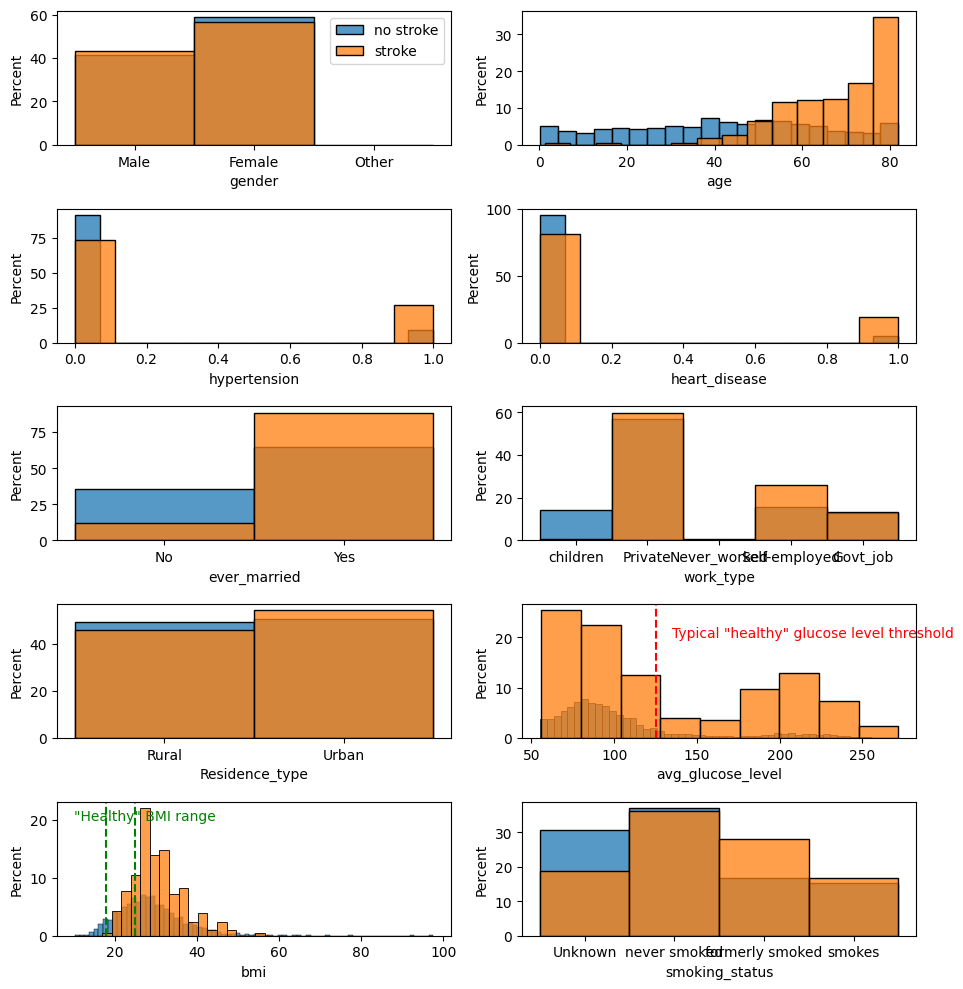

In [12]:
fig, axes = plt.subplots(5,2, figsize=(10,10))
stroke_df = df[df['stroke'] == 1]
nostroke_df = df[df['stroke'] == 0]
cols_no_stroke = [col for col in cols if col != 'stroke']

ax = axes.ravel()

for i in range(10):
    # sns.histplot(data=df, x=cols_no_stroke[i], hue='stroke', stat='density', ax=ax[i])
    sns.histplot(data = nostroke_df, x=cols_no_stroke[i], stat='percent', ax=ax[i])
    sns.histplot(data = stroke_df, x=cols_no_stroke[i], stat='percent', ax=ax[i])

    # additional vertical lines
    dist_col = cols_no_stroke[i]
    if dist_col == 'bmi':
        ax[i].axvline(x=18, ymin=0, ymax=30, color="green", linestyle="dashed")
        ax[i].axvline(x=25, ymin=0, ymax=30, color="green", linestyle="dashed")
        ax[i].text(10, 20, '"Healthy" BMI range', color="green")
    if dist_col == "avg_glucose_level":
        ax[i].axvline(x=125, ymin=0, ymax=30, color="red", linestyle="dashed")
        ax[i].text(135, 20, 'Typical "healthy" glucose level threshold', color="red")
ax[0].legend(['no stroke', 'stroke'], loc='best')
fig.tight_layout()

### Neural nets
Initially, let's work on the cleaned and encoded dataset (all numerical columns), with scaling to 0-1 applied, as the spread of value ranges within the dataset is quite large, next, if necessary an exploration with engineered features such as binning bmi or average glucose levels and encoding these bin categories

#### X-y split

In [4]:
X = df_enc.drop(['stroke'], axis=1)
y = pd.DataFrame(df_enc['stroke'])

Important! As this is a **significantly imbalanced** dataset (only about 5% of cases are of label '1'), whilst splitting the data, you need to stratify on the target labels, which, in scikit-learn will ensure the data is split to keep the proportion of classes within the sets intact **(done in test_nn_model function)**

In [29]:
# y_train = pd.DataFrame(y_train)
# y_test = pd.DataFrame(y_test)

### Function to compile and test classification NN models
* accepts model, X and y
* to scale or not to scale
* to early stop, lr_schedule, loss choice etc

In [5]:
# data_dict = {
#     'X_train': X_train,
#     'y_train': y_train,
#     'X_test': X_test,
#     'y_test': y_test
# }

In [105]:
def test_nn_model_classif(model, X, y,
                  test_split = 0,
                  scale = True,
                  optimizer=tf.keras.optimizers.Adam,
                  metrics = None,
                  loss=tf.keras.losses.BinaryCrossentropy, lr=0.001, batch_size=256, epochs=50,
                  verbose = False,
                  early_stop=True, lr_schedule=False):
    """
    Trains a NN model that you supply (uncompiled), along with data X, y, whether to scale and other training params
    ---
    Params:
        model
        X - dataframe of factors
        y - target dataframe / series
        test_split: int (default: 0) - the size of the test split, if necessary, will be split if test_split > 0
        scale: bool (default: True) - to MinMaxScale (to 0-1) or not
        optimizer: tf.keras.optimizer function object (default: tf.keras.optimizers.Adam)
        metrics: list (eg. ['accuracy'])
        loss: tf.keras.losses function object (default: tf.keras.losses.BinaryCrossentropy)
        batch_size: int (default: 256)
        epochs: int (default 50)
        verbose: bool (default: False)
        early_stop: bool (default: True)
        lr_schedule: bool (default: False)
    ---
    Returns:
        history - model training (fit) history object
        X_test - the train data used
        y_test
        scaler_X - the scaler used for input (X) values
        accuracy
    """

    # train-test-split
    X_cols = list(X.columns)
    y_col = list(y.columns)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify = y, test_size=test_split)

    if scale == True:
        scaler_X = MinMaxScaler()
        scaler_X.fit(X_train[X_cols])

        # this is a classification problem! we'd like to keep the classes as numbers / the output
        # function/activation doesn't care about the numbers, it returns probabilities
        
        # scaler_y = MinMaxScaler()
        # scaler_y.fit(pd.DataFrame(y_train))

        X_train[X_cols] = scaler_X.transform(X_train[X_cols])
        X_test[X_cols] = scaler_X.transform(X_test[X_cols])
        # y_train[y_col] = scaler_y.transform(y_train[y_col])
        # y_test = scaler_y.transform(y_test[y_col])
    
    # prepare the learning rate decay
    # https://stackoverflow.com/questions/61552475/
    # properly-set-up-exponential-decay-of-learning-rate-in-tensorflow
    train_size = X_train.shape[0]
    initial_lr = lr
    final_lr = initial_lr / 100
    lr_decay_factor  = (final_lr / initial_lr) ** (1/epochs)
    steps_per_epoch = int(train_size/batch_size)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_lr,
                decay_steps=steps_per_epoch,
                decay_rate=lr_decay_factor,
                staircase=True)

    #optimizer
    if lr_schedule == True:
        optim = optimizer(
            learning_rate = lr_schedule
        )
    else:
        optim = optimizer(
            learning_rate = lr
        )

    # model compilation   
    model.compile(
        optimizer = optim,
        loss = loss,
        metrics = metrics
    )
                          
    # prepare early stopping                    
    early_stopping = EarlyStopping(
        # min_delta=0.001, # minimium amount of change to count as an improvement
        # patience=10, # how many epochs to wait before stopping
        monitor = 'val_prc',
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True,
    )

    # model training
    if early_stop == True:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            batch_size = batch_size,
            epochs = epochs,
            callbacks = [early_stopping],
            verbose = verbose
        )
    else:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            batch_size = batch_size,
            epochs = epochs,
            verbose = verbose
        )

    # convert the training history to a dataframe
    history_df = pd.DataFrame(history.history)
    # use Pandas native plot method
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    sns.lineplot(history_df['loss'], ax=ax)
    sns.lineplot(history_df['val_loss'], ax=ax)
    ax.legend(['training loss', 'validation loss'], loc='best')
    # sns.histplot(data = nostroke_df, x=cols_no_stroke[i], stat='percent', ax=ax[i])
    # history_df['loss'].plot(ax = ax);
    # history_df['val_loss'].plot(ax = ax);
    ax.set_xlabel('epochs')
    fig.show()

    # predictions, unscaling etc
    y_pred = model.predict(X_test)
    
    # mae = mean_absolute_error(y_test, y_pred)
    # print('mae: ', mae)
    # if scale == True:
    #     mae_inv = mean_absolute_error(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(y_pred))
    #     print('mae on inv scaled:', mae_inv)
    #     return X_test, y_test, mae, mae_inv, scaler_X, scaler_y

    loss_value, accuracy, precision, recall, auc, prc = model.evaluate(X_test, y_test)
    print('Accuracy achieved: ', accuracy)

    # return mae
    return history, X_test, y_test, scaler_X, accuracy

In [9]:
n_features = X.shape[1]
n_features

17

In [10]:
output_shape = int(y.nunique().iloc[0])
output_shape

2

In [67]:
model_1 = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[n_features]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

 1/40 [..............................] - ETA: 0s - loss: 0.1168 - accuracy: 0.9688

C:\Users\User\AppData\Local\Temp\ipykernel_4076\1861112976.py:124: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


40/40 [==============================] - 0s 1ms/step - loss: 0.1570 - accuracy: 0.9515
Accuracy achieved:  0.9514867067337036


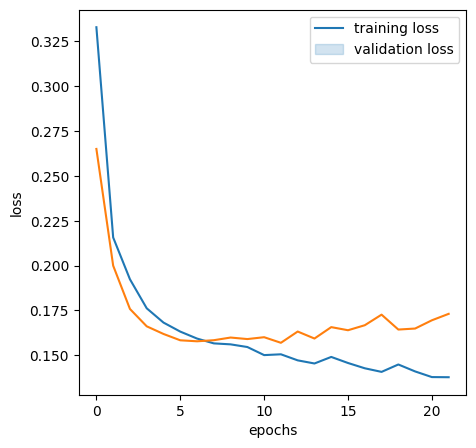

In [68]:
history, X_test, y_test, scaler_X, accuracy = test_nn_model_classif(model_1, X, y,
              scale = True,
              test_split = 0.25,
              optimizer=keras.optimizers.Adam,
              metrics = ['accuracy'],
              loss=tf.keras.losses.binary_crossentropy,
              lr=0.001, batch_size=512, epochs=50,
              early_stop=True, lr_schedule=True)

In [69]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.332943,0.942067,0.265081,0.951487
1,0.215729,0.951200,0.200011,0.951487
2,0.192415,0.951200,0.175861,0.951487
3,0.176228,0.951200,0.166180,0.951487
4,0.168262,0.951200,0.161919,0.951487


In [70]:
model_1.evaluate(X_test, y_test)

40/40 [==============================] - 0s 1ms/step - loss: 0.1570 - accuracy: 0.9515


[0.15698623657226562, 0.9514867067337036]

A 95% accuracy.. nice, right? Well, not quite. It could just mean the model is guessing 0 everytime, as the percentage of class 0 within the dataset is.. 95%. Let's look at the results further

In [71]:
y_pred = model_1.predict(X_test)
y_pred_binary = tf.round(y_pred)

40/40 [==============================] - 0s 1ms/step


In [72]:
model_1_report = classification_report(y_test, y_pred_binary)
print(model_1_report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278



C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

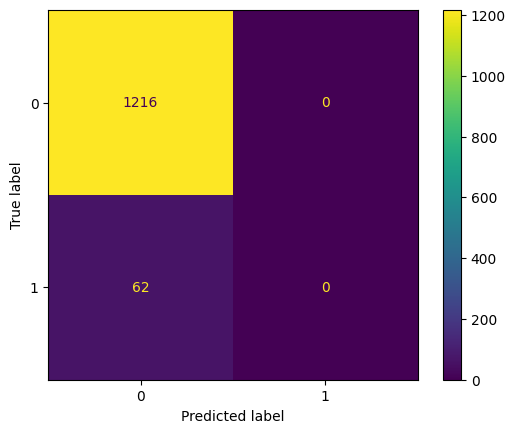

In [73]:
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(cm, display_labels = ["0", "1"])
disp.plot()

Indeed - the recall for class 1 is preciselly.. 0. Not at all what we needed

### Class imbalance mitigation

#### Classification threshold

In [74]:
y_pred[:, 0]

array([0.02832558, 0.03180496, 0.07834445, ..., 0.00620406, 0.0036589 ,
       0.00963855], dtype=float32)

In [86]:
preds_thresh = (y_pred[:,0] >= 0.06).astype('int')
preds_thresh

array([0, 0, 1, ..., 0, 0, 0])

In [87]:
unique, counts = np.unique(preds_thresh, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 897]
 [  1 381]]


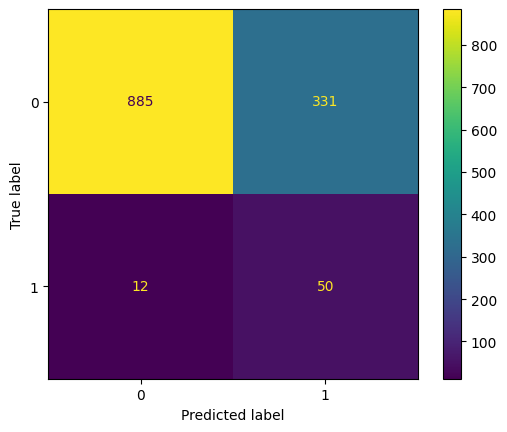

In [88]:
cm = confusion_matrix(y_test, preds_thresh)
disp = ConfusionMatrixDisplay(cm, display_labels = ["0", "1"])
disp.plot()

In [89]:
model_1_report_thresh = classification_report(y_test, preds_thresh)
print(model_1_report_thresh)

              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1216
           1       0.13      0.81      0.23        62

    accuracy                           0.73      1278
   macro avg       0.56      0.77      0.53      1278
weighted avg       0.95      0.73      0.81      1278



Okay, with just adjusting the threshold we were able to get slightly (but, nonetheless, existing) better results, with a slightly better recall for class "1" with a noticeable lesser sacrifice to class's "0" precision.

### Proper NN initial bias (for class weights) adjustment

In [93]:
pos = y[y['stroke'] == 1].shape[0]
neg = y[y['stroke'] == 0].shape[0]

In [94]:
initial_bias = np.log([pos/neg])
initial_bias

array([-2.97154656])

In [95]:
output_bias = tf.keras.initializers.Constant(initial_bias)

In [109]:
model_2 = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[n_features]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
])

Restoring model weights from the end of the best epoch: 1.
Epoch 11: early stopping
 1/40 [..............................] - ETA: 0s - loss: 0.1691 - accuracy: 0.9375 - precision: 1.0000 - recall: 0.3333 - auc: 0.9425 - prc: 0.6593

C:\Users\User\AppData\Local\Temp\ipykernel_4076\2441934176.py:128: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


40/40 [==============================] - 0s 1ms/step - loss: 0.1281 - accuracy: 0.9523 - precision: 0.5200 - recall: 0.2097 - auc: 0.9103 - prc: 0.4152
Accuracy achieved:  0.9522691965103149


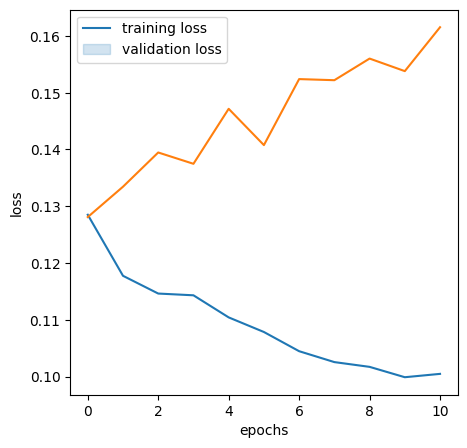

In [110]:
history, X_test, y_test, scaler_X, accuracy = test_nn_model_classif(model_1, X, y,
              scale = True,
              test_split = 0.25,
              optimizer=keras.optimizers.Adam,
              metrics = [
                  keras.metrics.BinaryAccuracy(name='accuracy'),
                  keras.metrics.Precision(name='precision'),
                  keras.metrics.Recall(name='recall'),
                  keras.metrics.AUC(name='auc'), 
                  keras.metrics.AUC(name='prc', curve='PR') #precision-recall curve
              ],
              loss=tf.keras.losses.binary_crossentropy,
              lr=0.001, batch_size=512, epochs=50,
              early_stop=True, lr_schedule=True)

40/40 [==============================] - 0s 975us/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278



C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\Desktop\programowanie_web_etc\python_projects\ml_zoo\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

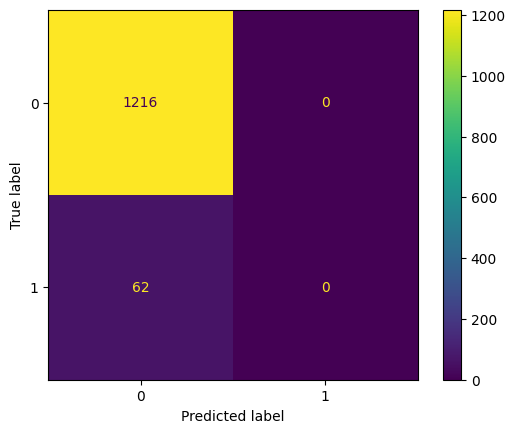

In [111]:
y_pred = model_2.predict(X_test)
y_pred_binary = tf.round(y_pred)

model_1_report = classification_report(y_test, y_pred_binary)
print(model_1_report)

cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(cm, display_labels = ["0", "1"])
disp.plot()

## TODO:
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data